##  Multi-scale feature learning dynamics
Attempt to reproduce Figure 1 in "Multi-scale-feature dynamics..." and compare with empirical curves.

In [1]:
import numpy as np
#import matplotlib as mpl
#mpl.use('tkagg')
from scipy.stats import ortho_group
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(1234)

In [2]:
# Some help functions, taken (and adapted) from https://github.com/mpezeshki/Epoch_wise_Double_Descent/tree/main

def get_modulation_matrix(d, p, k):
    U = ortho_group.rvs(d)
    VT = ortho_group.rvs(d)
    S = np.eye(d)
    S[:p, :p] *= 1
    S[p:, p:] *= 1 / k
    F = np.dot(U, np.dot(S, VT))
    return F


# Implements the teacher and generates the data
def get_data(seed, n, d, p, k, noise):
    np.random.seed(seed)
    Z = np.random.randn(n, d) / np.sqrt(d)
    Z_test = np.random.randn(1000, d) / np.sqrt(d)

    # the modulation matrix that controls students access to the data
    F = get_modulation_matrix(d, p, k)

    # X = F^T Z
    X = np.dot(Z, F)
    X_test = np.dot(Z_test, F)

    # teacher
    w = np.random.randn(d, 1)
    y = np.dot(Z, w)
    y = y + noise * np.random.randn(*y.shape)
    # test data is noiseless
    y_test = np.dot(Z_test, w)

    return X, y, X_test, y_test, F, w


def get_RQ_theoretical(L, Ft, FtInv, d, eta, l2, noise, t):
    
    # R: the alignment between the teacher and the student
    
    D = np.eye(d) - (np.eye(d) - eta * L)**t
    D2 = np.dot(L,  np.linalg.inv(L + l2 * np.eye(d)))
    R = np.trace(np.dot(D, D2)) / d
    
    # Q: the student's modulated norm
    D3 = np.dot(np.dot(Ft, D), D2)
    A = np.dot(D3, FtInv)
    B = np.dot(D3, np.linalg.inv(L**0.5))
    Q = (np.trace(np.dot(A.T, A)) + noise * np.trace(np.dot(B.T, B))) / d
    
    return R, Q

def get_RQ_empirical(w_hat, F, w, d):
    # R: the alignment between the teacher and the student
    R = np.dot(np.dot(F, w_hat).T, w).item() / d
    # Q: the student's modulated norm
    Q = np.dot(np.dot(F, w_hat).T, np.dot(F, w_hat)).item() / d
    return R, Q

def get_w_hat_gd(X, y, l2):
    return np.linalg.inv(np.dot(X.T, X) + l2 * np.eye(X.shape[-1])) @ X.T @ y

def training_step(X, w_hat, w_hat_gd, eta, l2, t):
    d = w_hat.shape[0]
    return (np.eye(d) - ((1-eta * l2) * np.eye(d) - eta * np.dot(X.T, X))**t) @ w_hat_gd


def get_loss_theoretical(R, Q, noise):
    return 0.5 * (1 + noise + Q - 2*R)

def get_loss_empirical(R, Q):
    return 0.5 * (1 + Q - 2*R) # Or should we account for the label noise somehow?

In [3]:
# n: number of training examples
n = 130
# d: number of total dimensions
d = 100
# p: number of fast learning dimensions
p = 50
# k: kappa -> the condition number of the modulation matrix, F
k = 100
# standard deviation of the noise added to the teacher output
noise = 0.0
# L2 regularization coefficient
l2 = 0.0
# eta: learning rate
eta = 0.1
# T: Num training iterations
T = 100

In [4]:
# Theoretical curves
def get_theoretical_results(X, F, d, eta, l2, noise, T):

    # Some help vars
    _, S, Vh = np.linalg.svd(F, full_matrices=True) # X.T@X = F.T@F=VSV.T in expectation (but not sure all expressions pan out)
    # It also makes a very big difference whether I use X or F, so...
    
    if S.shape[0] == d: # Full rank (which we kind of expect it to have)
        L = np.diag(S)
    else:
        L = np.diag(np.array([S, np.zeros((d - S.shape[0]))]))
    
    assert L.shape == (d, d) # TODO: Vad händer om d > n?
    
    Ft = np.dot(F, Vh.T)
    FtInv = np.linalg.inv(Ft)
    
    loss_gen = np.zeros((T,))
    for t in range(T):
        R, Q = get_RQ_theoretical(L, Ft, FtInv, d, eta, l2, noise, t)
        loss_gen[t] = get_loss_theoretical(R, Q, noise)
       
    return loss_gen

In [5]:
seeds = range(10)

loss_gen, loss_gen_fast, loss_gen_slow = np.zeros((T,)), np.zeros((T,)), np.zeros((T,))
for seed in seeds:
    X, _, _, _, F, _ = get_data(seed, n, d, p, k, noise)
    loss_gen += get_theoretical_results(X, F, d, eta, l2, noise, T) / len(seeds)
    
    # Train fast features only
    loss_gen_fast += get_theoretical_results(X[:, :p], F[:p, :p], p, eta, l2, noise, T) / len(seeds)
    
    # Train slow features only
    loss_gen_slow += get_theoretical_results(X[:, p:], F[p:, p:], d-p, eta, l2, noise, T) / len(seeds)


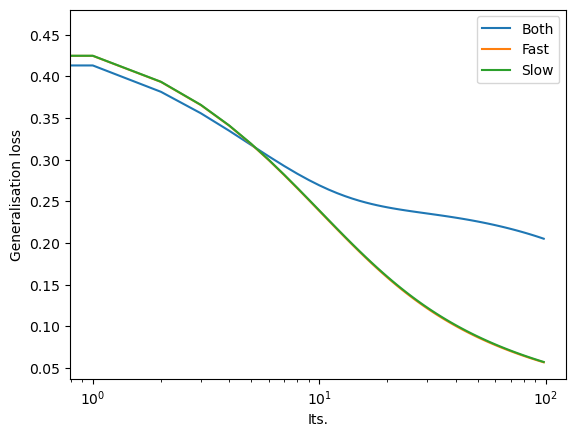

In [6]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(loss_gen[1:], label="Both")
ax.plot(loss_gen_fast[1:], label="Fast")
ax.plot(loss_gen_slow[1:], label="Slow")
ax.legend()
ax.set_xlabel("Its.")
ax.set_ylabel("Generalisation loss")
plt.show()

In [7]:
# Empirical curves
def get_empirical_results(X, y, F, w, d, eta, l2, noise, T):

    # Some help vars
    w_hat_gd = get_w_hat_gd(X, y, l2)

    w_hat = np.zeros((d, 1))
    loss = np.zeros((T,))
    loss_gen = np.zeros((T,))
    for t in range(T):
        w_hat = training_step(X, w_hat, w_hat_gd, eta, l2, t)
        R, Q = get_RQ_empirical(w_hat, F, w, d)
        loss[t] = ((y - X @ w_hat)**2).mean() 
        loss_gen[t] = get_loss_theoretical(R, Q, noise)
        
    return loss, loss_gen

In [8]:
seeds = range(1)

# TODO: Jag vet inte hur de menar att de tränar bara fast/slow features; det kan vara så här 
# (men jag verkar få dd för fast features bara, kan vara att detta är empiriskt)
loss, loss_gen, loss_gen_fast, loss_gen_slow = np.zeros((T,)), np.zeros((T,)), np.zeros((T,)), np.zeros((T,))
for seed in seeds:
    # This is still when we have taken expectation w.r.t. z already (so perhaps not entirely correct to call it empirical)
    X, y, X_test, y_test, F, w = get_data(seed, n, d, p, k, noise)

    # Train all features
    l, lg = get_empirical_results(X, y, F, w, d, eta, l2, noise, T)  # How am I supposed to get an estimate of the noise, without it being equal to the MSE??
    loss += l / len(seeds)
    loss_gen += lg / len(seeds)
    
    # Train fast features only
    #eta_d = np.zeros((d,))
    #eta_d[:p] = eta
    _, lg = get_empirical_results(X[:, :p], y, F[:p, :p], w[:p], p, eta, l2, noise, T)
    loss_gen_fast += lg / len(seeds)
    
    # Train slow features only
    #eta_d = np.zeros((d,))
    #eta_d[p:] = eta
    _, lg = get_empirical_results(X[:, p:], y, F[p:, p:], w[p:], d-p, eta, l2, noise, T) 
    loss_gen_slow += lg / len(seeds)

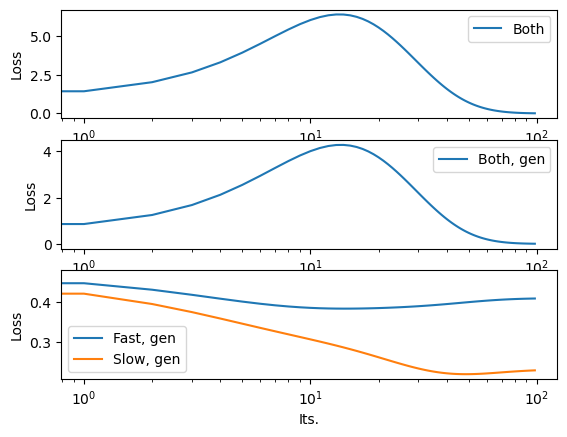

In [9]:
fig, ax = plt.subplots(3, 1)
ax[0].plot(loss[1:], label="Both") # TODO: detta är inte så träningslossen blir med github-kod
ax[1].plot(loss_gen[1:], label="Both, gen")
ax[2].plot(loss_gen_fast[1:], label="Fast, gen")
ax[2].plot(loss_gen_slow[1:], label="Slow, gen")

for k in range(3):
    ax[k].set_xscale('log')
    ax[k].legend()
    ax[k].set_xlabel("Its.")
    ax[k].set_ylabel("Loss")
        
plt.show()

### Loss surface

In [ ]:

def plot_loss_surface(seed, k, noise, w_min=-10.0, w_max=10.0, w_step=0.1): 
    d, p, n = 2, 1, 1 # We do this only in two dimensions
    _, _, _, _, F, w = get_data(seed, n, d, p, k, noise)

    u, v = np.arange(w_min, w_max, w_step), np.arange(w_min, w_max, w_step)
    U, V = np.meshgrid(u, v)
    U, V = U.astype(np.float32), V.astype(np.float32)

    nu, nv = u.shape[0], v.shape[0]
    losses = np.zeros((nv, nu))
    for i in range(nu):
        for j in range(nv):
            # Set model weights
            w_hat = np.array([U[j, i], V[j, i]]).reshape(-1, 1)

            # Calculate loss
            R, Q = get_RQ_empirical(w_hat, F, w, d)
            losses[j, i] = get_loss_theoretical(R, Q, noise)
            
    fig, ax = plt.subplots()
    im1 = ax.imshow(losses)
    ax.plot()
    fig.colorbar(im1, ax=ax)

    tick_step = int(nu / 4)
    ax.set_xticks([i for i in range(nu + 1) if np.mod(i, tick_step) == 0])
    ax.set_xticklabels([w_min + i * (w_max - w_min) / nu for i in range(nu + 1) if np.mod(i, tick_step) == 0])
    ax.set_xlabel("u")

    ax.set_yticks([i for i in range(nv + 1) if np.mod(i, tick_step) == 0])
    ax.set_yticklabels([w_min + i * (w_max - w_min) / nu for i in range(nv + 1) if np.mod(i, tick_step) == 0])
    ax.set_ylabel("v")
    
    plt.show()
            
    return losses

In [ ]:
losses = plot_loss_surface(12, k, noise)

In [10]:
U, S, V = np.linalg.svd(X)

In [11]:
print(S)

[1.76240874 1.74376043 1.69552029 1.67698496 1.61644553 1.60459526
 1.56334509 1.5111599  1.47946656 1.43196961 1.38891537 1.37133839
 1.35823437 1.34524405 1.31175072 1.29988259 1.28063909 1.24826782
 1.241196   1.21071155 1.13446743 1.11720447 1.11457735 1.07706971
 1.04988472 1.04232326 1.02894633 1.00092754 0.98092754 0.96661865
 0.95268363 0.91097768 0.88978849 0.87015858 0.85791922 0.83547992
 0.80132902 0.7674643  0.74595401 0.72341372 0.69614421 0.67628608
 0.66060338 0.62415185 0.60115204 0.58802128 0.56770289 0.53182335
 0.4718912  0.46963458 0.01497843 0.01460995 0.01415101 0.01343367
 0.01309949 0.01307627 0.01270884 0.01235128 0.0122415  0.01187029
 0.01167098 0.01150293 0.0110136  0.010878   0.01068158 0.01058951
 0.00989793 0.00962463 0.00952397 0.00933176 0.00909405 0.00896274
 0.00866015 0.00860478 0.00806225 0.00793897 0.00769017 0.0074734
 0.00723192 0.00675143 0.00652808 0.0064176  0.00623079 0.00605745
 0.00583829 0.00577877 0.00545687 0.00534606 0.00515188 0.00469